# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from scipy.optimize import curve_fit
import seaborn as sbn
import warnings
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

# EXPLORACION DE DATOS Y MEDICION DE K

Primero que nada, voy a cargar los datos, a revisar un poco los registros y columnas, analizandolas una por una para entender que significan cada una de ellas, para luego poder concluir con que datos contamos para poder transformarlos en informacion util para nuestra interpretacion y determinacion de conclusiones.

In [3]:
# Vamos a comenzar cargando todo nuestro dataset en una nueva variable "datos"
datos=pd.read_csv('owid-covid-data.csv')
datos

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117016,ZWE,Africa,Zimbabwe,2021-09-11,126220.0,57.0,113.571,4536.0,4.0,10.000,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
117017,ZWE,Africa,Zimbabwe,2021-09-12,126269.0,49.0,102.714,4538.0,2.0,8.000,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
117018,ZWE,Africa,Zimbabwe,2021-09-13,126399.0,130.0,104.000,4543.0,5.0,7.143,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
117019,ZWE,Africa,Zimbabwe,2021-09-14,126817.0,418.0,145.857,4550.0,7.0,6.714,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN


In [5]:
# Analizamos la informacion del dataset, la cantidad de registros y las columnas
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117021 entries, 0 to 117020
Data columns (total 62 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               117021 non-null  object 
 1   continent                              111668 non-null  object 
 2   location                               117021 non-null  object 
 3   date                                   117021 non-null  object 
 4   total_cases                            111277 non-null  float64
 5   new_cases                              111274 non-null  float64
 6   new_cases_smoothed                     110259 non-null  float64
 7   total_deaths                           100616 non-null  float64
 8   new_deaths                             100771 non-null  float64
 9   new_deaths_smoothed                    110259 non-null  float64
 10  total_cases_per_million                110690 non-null  

Analizamos en profundidad el significado de cada columna, para una mayor comprension del dataset. Es muy importante comprender el significado del dato cuando lo tengamos que interpretar, de esta manera evitamos un mal analisis. Son 62 columnas y se deja a continuacion el detalle de todas para futuros usos: 

    1. iso_code : ISO 3166-1 alpha-3 – three-letter country codes
    2. continent: Continent of the geographical location
    3. location: Geographical location
    4. date: Date of observation
    5. total_cases: Total confirmed cases of COVID-19. Counts can include probable cases, where reported.
    6. new_cases: New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA.
    7. new_cases_smoothed: New confirmed cases of COVID-19 (7-day smoothed). Counts can include probable cases, where reported.
    8. total_deaths: Total deaths attributed to COVID-19. Counts can include probable deaths, where reported.
    9. new_deaths: New deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA.                                 
    10. new_deaths_smoothed: New deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported.
    11. total_cases_per_million: Total confirmed cases of COVID-19 per 1,000,000 people. Counts can include probable cases, where reported.
    12. new_cases_per_million: New confirmed cases of COVID-19 per 1,000,000 people. Counts can include probable cases, where reported.
    13. new_cases_smoothed_per_million: New confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people. Counts can include probable cases, where reported.
    14. total_deaths_per_million: Total deaths attributed to COVID-19 per 1,000,000 people. Counts can include probable deaths, where reported.
    15. new_deaths_per_million: New deaths attributed to COVID-19 per 1,000,000 people. Counts can include probable deaths, where reported.
    16. new_deaths_smoothed_per_million: New deaths attributed to COVID-19 (7-day smoothed) per 1,000,000 people. Counts can include probable deaths, where reported.
    17. reproduction_rate: Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database
    18. icu_patients: Number of COVID-19 patients in intensive care units (ICUs) on a given day
    19. icu_patients_per_million: Number of COVID-19 patients in intensive care units (ICUs) on a given day per 1,000,000 people
    20. hosp_patients: Number of COVID-19 patients in hospital on a given day
    21. hosp_patients_per_million: Number of COVID-19 patients in hospital on a given day per 1,000,000 people 
    22. weekly_icu_admissions: Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week
    23. weekly_icu_admissions_per_million: Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week per 1,000,000 people
    24. weekly_hosp_admissions: Number of COVID-19 patients newly admitted to hospitals in a given week
    25. weekly_hosp_admissions_per_million: Number of COVID-19 patients newly admitted to hospitals in a given week per 1,000,000 people
    26. new_tests: New tests for COVID-19 (only calculated for consecutive days)
    27. total_tests: Total tests for COVID-19
    28. total_tests_per_thousand: Total tests for COVID-19 per 1,000 people
    29. new_tests_per_thousand: New tests for COVID-19 per 1,000 people
    30. new_tests_smoothed: New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window
    31. new_tests_smoothed_per_thousand: New tests for COVID-19 (7-day smoothed) per 1,000 people
    32. positive_rate: The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)
    33. tests_per_case: Tests conducted per new confirmed case of COVID-19, given as a rolling 7-day average (this is the inverse of positive_rate) 
    34. tests_units: Units used by the location to report its testing data 
    35. total_vaccinations: Total number of COVID-19 vaccination doses administered
    36. people_vaccinated: Total number of people who received at least one vaccine dose
    37. people_fully_vaccinated: Total number of people who received all doses prescribed by the initial vaccination protocol
    38. total_boosters: Total number of COVID-19 vaccination booster doses administered (doses administered beyond the number prescribed by the vaccination protocol)
    39. new_vaccinations: New COVID-19 vaccination doses administered (only calculated for consecutive days)
    40. new_vaccinations_smoothed: New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window
    41. total_vaccinations_per_hundred: Total number of COVID-19 vaccination doses administered per 100 people in the total population
    42. people_vaccinated_per_hundred: Total number of people who received at least one vaccine dose per 100 people in the total population
    43. people_fully_vaccinated_per_hundred: Total number of people who received all doses prescribed by the initial vaccination protocol per 100 people in the total population 
    44. total_boosters_per_hundred: Total number of COVID-19 vaccination booster doses administered per 100 people in the total population
    45. new_vaccinations_smoothed_per_million: New COVID-19 vaccination doses administered (7-day smoothed) per 1,000,000 people in the total population
    46. stringency_index: Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)
    47. population: Population (latest available values). See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv for full list of sources
    48. population_density: Number of people divided by land area, measured in square kilometers, most recent year available 
    49. median_age: Median age of the population, UN projection for 2020
    50. aged_65_older: Share of the population that is 65 years and older, most recent year available
    51. aged_70_older: Share of the population that is 70 years and older in 2015
    52. gdp_per_capita: Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available
    53. extreme_poverty: Share of the population living in extreme poverty, most recent year available since 2010
    54. cardiovasc_death_rate: Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) 
    55. diabetes_prevalence: Diabetes prevalence (% of population aged 20 to 79) in 2017
    56. female_smokers: Share of women who smoke, most recent year available
    57. male_smokers: Share of men who smoke, most recent year available
    58. handwashing_facilities: Share of the population with basic handwashing facilities on premises, most recent year available 
    59. hospital_beds_per_thousand: Hospital beds per 1,000 people, most recent year available since 2010
    60. life_expectancy: Life expectancy at birth in 2019
    61. human_development_index: human_development_index	A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506
    62. excess_mortality: Percentage difference between the reported number of weekly or monthly deaths in 2020–2021 and the projected number of deaths for the same period based on previous years. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality

In [6]:
# Visualizamos los primeros 5 registros
datos.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [7]:
‹# Filtramos paises con valores unicos
# Para comenzar a entender cuales son los paises con lo que contamos informacion sobre covid y conocer mas sobre nuestro dataset. 
datos['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [8]:
# Total de paises
datos['location'].unique().shape

(233,)

In [10]:
# Analizamos valores maximos de cada columna. 
# (en caso de valores numericos como "new_cases" o "total_cases" veremos cual es el mayor numero registrado)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
print(datos.max())

iso_code                                          ZWE
location                                     Zimbabwe
date                                       2021-09-15
total_cases                               226478640.0
new_cases                                    906034.0
new_cases_smoothed                         826428.571
total_deaths                                4659842.0
new_deaths                                    17976.0
new_deaths_smoothed                         14722.714
total_cases_per_million                    208199.373
new_cases_per_million                         8620.69
new_cases_smoothed_per_million               3385.473
total_deaths_per_million                     5961.136
new_deaths_per_million                        215.334
new_deaths_smoothed_per_million                63.007
reproduction_rate                                5.92
icu_patients                                  28889.0
icu_patients_per_million                      192.269
hosp_patients               

/var/folders/kr/9brdb4h16pjd4qnpb192jpb00000gn/T/ipykernel_1850/1132557456.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(datos.max())


In [12]:
# Cargamos vectores
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

## Análisis exploratorio de ARGENTINA

Text(0, 0.5, 'cantidad de casos')

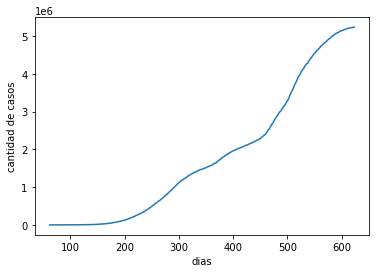

In [13]:
# Luego del rapido analisis de dataset comenzamos a profundizar en un pais.
# Elegimos como primer pais Argentina y lo analisamos:

ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

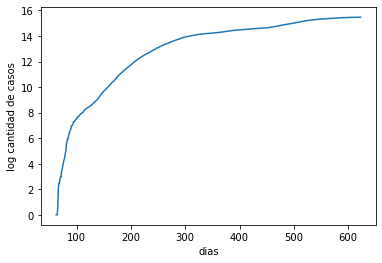

In [14]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 160 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

Text(0, 0.5, 'cantidad de casos')

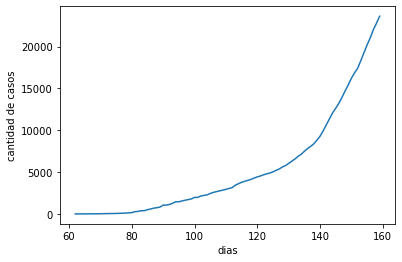

In [15]:
casos_principio=casos_arg[0:160]
dias_principio=dias[0:160]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

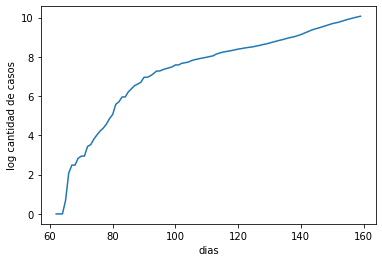

In [16]:

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 60 y 100, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

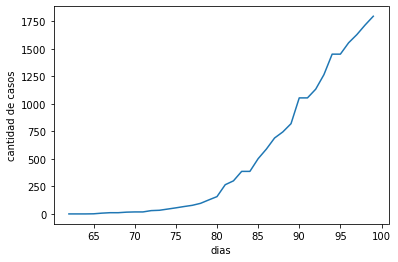

In [17]:
casos_principio=casos_arg[60:100]
dias_principio=dias[60:100]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

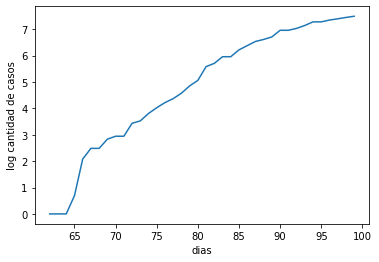

In [18]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [19]:
# Nos quedamos unicamente con los datos de argentina
# Reseteamos los indices para obtener una tabla limpia de resultados.
arg = datos[datos['location'] == 'Argentina']
arg = arg.reset_index(drop=True)
arg.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,ARG,South America,Argentina,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000,0.000,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45605823.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,NaN
1,ARG,South America,Argentina,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,37.0,0.001,0.001,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45605823.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,NaN
2,ARG,South America,Argentina,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,41.0,0.001,0.000,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45605823.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,NaN


In [20]:
# Eliminamos valores nulos en las columnas: location, date y total_cases porque no aportan informacion relevante
# E intentamos averiguar el K usando el ajuste, donde los arreglos no pueden contener valores nulos.
arg = arg[['location','date','total_cases']].dropna()
casos_principio = arg.total_cases[10:45]
dias_principio = np.arange(0,len(casos_principio))

In [21]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [22]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([  0.07521594, -71.69874405])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

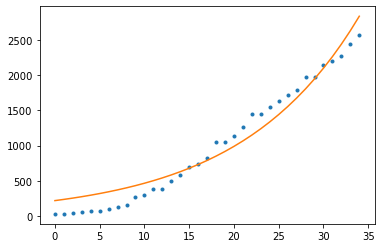

In [23]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [24]:
def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos   

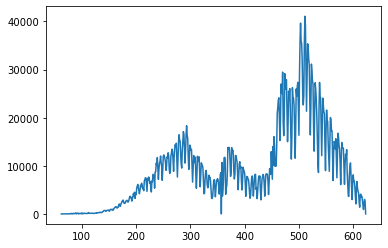

In [25]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

## Elegimos diez paises para realizar la medicion de K

El analisis que hicimos anteriormente con Argentina, lo vamos a realizar a continuacion pero con otros 10 paises, para ver si podemos entender el k mundial a partir del analiss de una poblicacion de paises seleccionados.
A partir del estudio de estos paises bien seleccionados y usando las herramientas estudiadas en el sprint, vamos a intentar comprender si es posible la prediccion del comportamiento global de la pandemia.
Me centrare en los proximos 10 paises:

1.	Alemania
2.	China
3.	Italia
4.	Peru
5.	Mexico
6.	Reino unido
7.	Sudafrica 
8.	Francia
9.	Brasil
10.	Estados unidos

Fueron elegidos los paises principalemnte que fueran potencia mundial como China (pais origen de pandemia), EEUU (pais con mas casos de covid a nivel mundial), Reino Unido, Francia y Alemania.
Luego se elige a Brasil (pais que tomo medidas conocidas mundialmente por su flexibilidad) y Sudafrica (pais de africa).
Tambien a pasis de america como Mexico y Peru (pais de america del norte y sur) y tambien a Italia de Europa.
Con la eleccion de estos paises vamos a tener un gran vistazo de los resultados a nivel global.

In [26]:
# Determinamos nuestra muestra, incluyendo solamente a los diez paises seleccionados.
Muestra=['United States','China','Italy','Peru','Mexico','United Kingdom','South Africa','France','Brazil','Germany']

In [27]:
# Utilizamos como filtro a la muestra de paises que definimos
datos_muestra=datos[datos.location.isin(Muestra)]
# Comprobamos que se haya realizado bien el filtrado:
datos_muestra['location'].unique()

array(['Brazil', 'China', 'France', 'Germany', 'Italy', 'Mexico', 'Peru',
       'South Africa', 'United Kingdom', 'United States'], dtype=object)

### 1. Alemania

In [35]:
alemania = datos_muestra[datos_muestra['location'] == 'Germany']
alemania = alemania.reset_index(drop=True)
alemania.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,DEU,Europe,Germany,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.353,0.481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN
1,DEU,Europe,Germany,2020-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.185,0.253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN
2,DEU,Europe,Germany,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.247,0.337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN


In [36]:
alemania = alemania[['location','date','total_cases']].dropna()

In [37]:
casos_principio = alemania.total_cases[25:35]
dias_principio = np.arange(0,len(casos_principio))

In [40]:
#ajustamos utilizando la funcion exponencial definida mas arriba dentro del proyecto
popt_ger, pcov_ger = curve_fit(exponencial, dias_principio, casos_principio)
popt_ger #valor de k

array([ 0.36780444, -4.0861916 ])

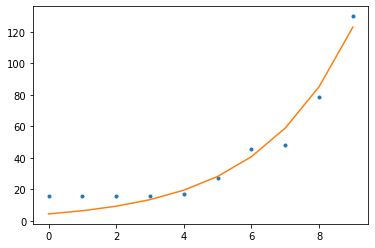

In [41]:
# Vemos como se ajusta lo que obtuvimos en relacion a los datos reales
k=popt_ger[0]
t0=popt_ger[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)


Text(0, 0.5, 'cantidad de casos')

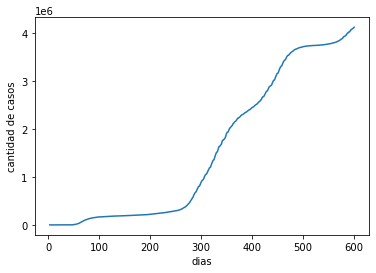

In [43]:
# Graficamos Alemania
ind_germany=np.where(paises=='Germany')
ind_germany=ind_germany[0]
casos_alemania=confirmados[ind_germany]
dias=np.arange(0,len(casos_alemania))
plt.plot(dias,casos_alemania)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

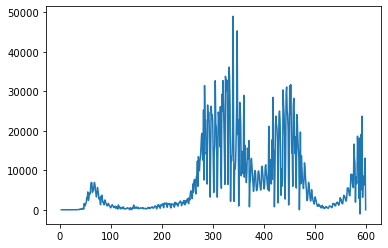

In [48]:
# Utilizamos la funcion "casos_nuevos" para analizar Alemania (la que definimos anteriormente cuando analizamos Argentina)
casos_alemania=np.array(casos_alemania)
nuevos_alemania=casos_nuevos(casos_alemania)
plt.plot(nuevos_alemania)

A continuacion se realizara para el resto de los paises lo que hicimos anteriormente. Comenzando con China:

### 2. China

In [49]:
china = datos_muestra[datos_muestra['location'] == 'China']
china = china.reset_index(drop=True)
china.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,CHN,Asia,China,2020-01-22,548.0,NaN,NaN,17.0,NaN,NaN,0.379,NaN,NaN,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.39,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN
1,CHN,Asia,China,2020-01-23,641.0,93.0,NaN,18.0,1.0,NaN,0.444,0.064,NaN,0.012,0.001,NaN,3.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.91,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN
2,CHN,Asia,China,2020-01-24,918.0,277.0,NaN,26.0,8.0,NaN,0.636,0.192,NaN,0.018,0.006,NaN,3.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.91,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN


In [50]:
china = china[['location','date','total_cases']].dropna()

In [51]:
casos_principio = china.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [52]:
casos_principio

10    11878.0
11    16615.0
12    19701.0
13    23690.0
14    27419.0
15    30563.0
16    34085.0
17    36788.0
18    39800.0
19    42316.0
20    44337.0
21    44709.0
22    59842.0
23    66302.0
24    68357.0
Name: total_cases, dtype: float64

In [53]:
# Ajustamos
popt_china, pcov_china = curve_fit(exponencial, dias_principio, casos_principio)
popt_china # Valor de k

array([  0.10116717, -96.26778783])

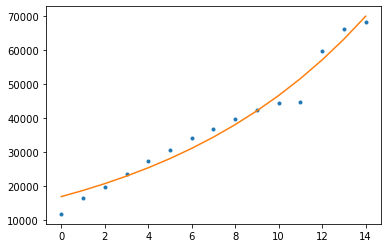

In [54]:
k=popt_china[0]
t0=popt_china[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

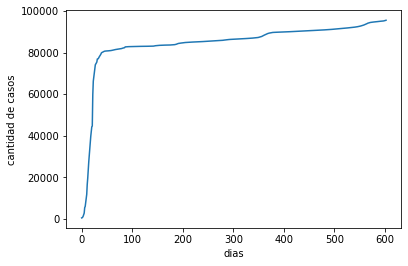

In [55]:
ind_china=np.where(paises=='China')
ind_china=ind_china[0]
casos_china=confirmados[ind_china]
dias=np.arange(0,len(casos_china))
plt.plot(dias,casos_china)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 3. Italia

In [56]:
italia = datos_muestra[datos_muestra['location'] == 'Italy']
italia = italia.reset_index(drop=True)
italia.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,ITA,Europe,Italy,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,0.033,0.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN
1,ITA,Europe,Italy,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,0.033,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN
2,ITA,Europe,Italy,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,0.033,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,-6.5


In [57]:
italia = italia[['location','date','total_cases']].dropna()

In [58]:
casos_principio = italia.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [59]:
casos_principio

10      3.0
11      3.0
12      3.0
13      3.0
14      3.0
15      3.0
16      3.0
17      3.0
18      3.0
19      3.0
20      3.0
21     20.0
22     62.0
23    155.0
24    229.0
Name: total_cases, dtype: float64

In [60]:
# Ajustamos
popt_italia, pcov_italia = curve_fit(exponencial, dias_principio, casos_principio)
popt_italia # Valor de k

array([0.64055398, 5.44844854])

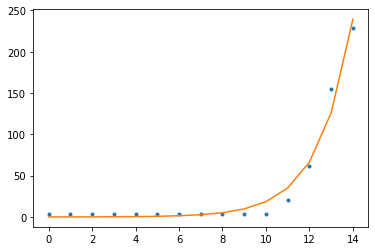

In [61]:
k=popt_italia[0]
t0=popt_italia[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

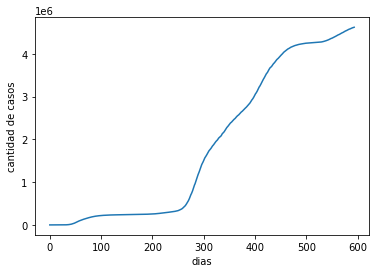

In [62]:
ind_italia=np.where(paises=='Italy')
ind_italia=ind_italia[0]
casos_italia=confirmados[ind_italia]
dias=np.arange(0,len(casos_italia))
plt.plot(dias,casos_italia)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 4. Peru

In [63]:
peru = datos_muestra[datos_muestra['location'] == 'Peru']
peru = peru.reset_index(drop=True)
peru.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,PER,South America,Peru,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33359415.0,25.129,29.1,7.151,4.455,12236.706,3.5,85.755,5.95,4.8,NaN,NaN,1.6,76.74,0.777,NaN
1,PER,South America,Peru,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33359415.0,25.129,29.1,7.151,4.455,12236.706,3.5,85.755,5.95,4.8,NaN,NaN,1.6,76.74,0.777,NaN
2,PER,South America,Peru,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33359415.0,25.129,29.1,7.151,4.455,12236.706,3.5,85.755,5.95,4.8,NaN,NaN,1.6,76.74,0.777,NaN


In [64]:
peru = peru[['location','date','total_cases']].dropna()

In [65]:
casos_principio = peru.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [66]:
casos_principio

75     86.0
76    117.0
77    145.0
78    234.0
79    234.0
80    318.0
81    363.0
82    395.0
83    416.0
84    480.0
85    580.0
86    635.0
87    671.0
88    852.0
89    950.0
Name: total_cases, dtype: float64

In [68]:
# Ajustamos
popt_peru, pcov_peru = curve_fit(exponencial, dias_principio, casos_principio)
popt_peru # Valor de k

array([  0.13662899, -36.21721652])

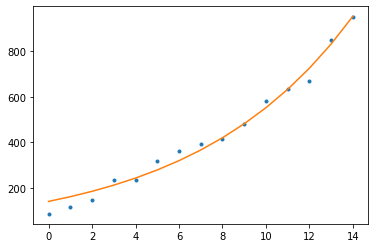

In [69]:
k=popt_peru[0]
t0=popt_peru[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

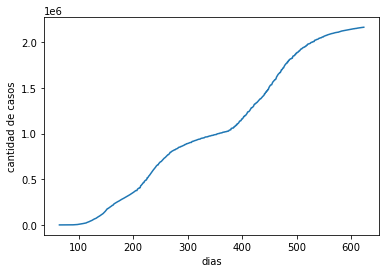

In [70]:
ind_peru=np.where(paises=='Peru')
ind_peru=ind_peru[0]
casos_peru=confirmados[ind_peru]
dias=np.arange(0,len(casos_peru))
plt.plot(dias,casos_peru)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 5. Mexico

In [71]:
mexico = datos_muestra[datos_muestra['location'] == 'Mexico']
mexico = mexico.reset_index(drop=True)
mexico.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN
1,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,97.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN
2,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,186.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN


In [72]:
mexico = mexico[['location','date','total_cases']].dropna()

In [73]:
casos_principio = mexico.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [74]:
casos_principio

68      7.0
69      7.0
70      8.0
71     12.0
72     26.0
73     41.0
74     53.0
75     82.0
76     93.0
77    118.0
78    164.0
79    203.0
80    251.0
81    316.0
82    367.0
Name: total_cases, dtype: float64

In [75]:
# Ajustamos
popt_mexico, pcov_mexico = curve_fit(exponencial, dias_principio, casos_principio)
popt_mexico # Valor de k

array([  0.23428827, -11.42455277])

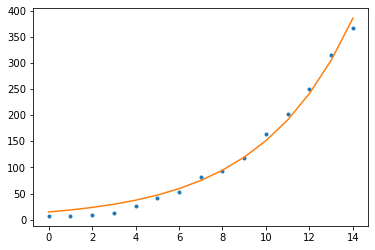

In [76]:
k=popt_mexico[0]
t0=popt_mexico[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

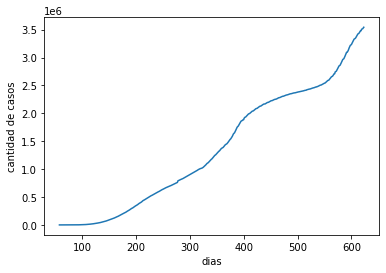

In [77]:
ind_mexico=np.where(paises=='Mexico')
ind_mexico=ind_mexico[0]
casos_mexico=confirmados[ind_mexico]
dias=np.arange(0,len(casos_mexico))
plt.plot(dias,casos_mexico)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 6. Reino Unido

In [78]:
reinoUnido = datos_muestra[datos_muestra['location'] == 'United Kingdom']
reinoUnido = reinoUnido.reset_index(drop=True)
reinoUnido.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,0.029,0.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,68207114.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
1,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,0.029,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,68207114.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
2,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,0.029,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,68207114.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,-5.15


In [79]:
reinoUnido = reinoUnido[['location','date','total_cases']].dropna()

In [80]:
casos_principio = reinoUnido.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [81]:
casos_principio

10    14.0
11    15.0
12    16.0
13    17.0
14    18.0
15    18.0
16    18.0
17    19.0
18    19.0
19    20.0
20    22.0
21    23.0
22    23.0
23    28.0
24    30.0
Name: total_cases, dtype: float64

In [83]:
# Ajustamos
popt_reinoUnido, pcov_reinoUnido = curve_fit(exponencial, dias_principio, casos_principio)
popt_reinoUnido # Valor de k

array([ 4.96539184e-02, -5.28549751e+01])

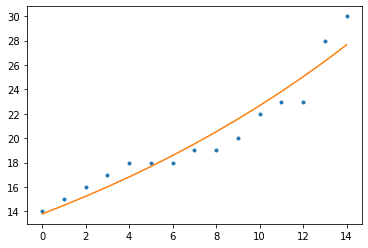

In [84]:
k=popt_reinoUnido[0]
t0=popt_reinoUnido[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

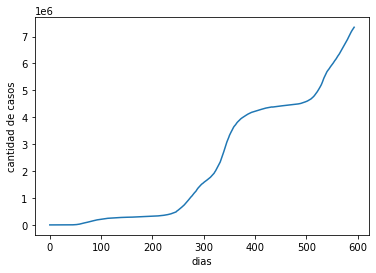

In [85]:
ind_reinoUnido=np.where(paises=='United Kingdom')
ind_reinoUnido=ind_reinoUnido[0]
casos_reinoUnido=confirmados[ind_reinoUnido]
dias=np.arange(0,len(casos_reinoUnido))
plt.plot(dias,casos_reinoUnido)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 7. Sudafrica

In [86]:
sudafrica = datos_muestra[datos_muestra['location'] == 'South Africa']
sudafrica = sudafrica.reset_index(drop=True)
sudafrica.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,ZAF,Africa,South Africa,2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,0.001,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996.0,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN
1,ZAF,Africa,South Africa,2020-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996.0,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN
2,ZAF,Africa,South Africa,2020-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996.0,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN


In [87]:
sudafrica = sudafrica[['location','date','total_cases']].dropna()

In [88]:
casos_principio = sudafrica.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [89]:
casos_principio

37      51.0
38      62.0
39      62.0
40     116.0
41     150.0
42     202.0
43     240.0
44     274.0
45     402.0
46     554.0
47     709.0
48     927.0
49    1170.0
50    1187.0
51    1280.0
Name: total_cases, dtype: float64

In [91]:
# Ajustamos
popt_sudafrica, pcov_sudafrica = curve_fit(exponencial, dias_principio, casos_principio)
popt_sudafrica # Valor de k

array([  0.1995823 , -22.46505862])

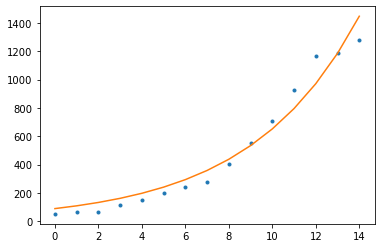

In [92]:
k=popt_sudafrica[0]
t0=popt_sudafrica[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

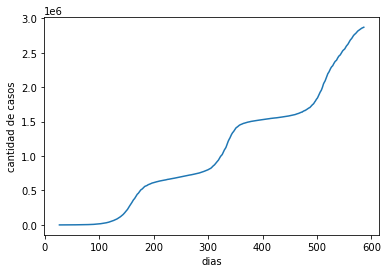

In [93]:
ind_sudafrica=np.where(paises=='South Africa')
ind_sudafrica=ind_sudafrica[0]
casos_sudafrica=confirmados[ind_sudafrica]
dias=np.arange(0,len(casos_sudafrica))
plt.plot(dias,casos_sudafrica)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 8. Francia

In [94]:
francia = datos_muestra[datos_muestra['location'] == 'France']
francia = francia.reset_index(drop=True)
francia.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,FRA,Europe,France,2020-01-24,2.0,2.0,NaN,NaN,NaN,NaN,0.030,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,67564251.0,122.578,42.0,19.718,13.079,38605.671,NaN,86.06,4.77,30.1,35.6,NaN,5.98,82.66,0.901,NaN
1,FRA,Europe,France,2020-01-25,3.0,1.0,NaN,NaN,NaN,NaN,0.044,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,67564251.0,122.578,42.0,19.718,13.079,38605.671,NaN,86.06,4.77,30.1,35.6,NaN,5.98,82.66,0.901,NaN
2,FRA,Europe,France,2020-01-26,3.0,0.0,NaN,NaN,NaN,NaN,0.044,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,67564251.0,122.578,42.0,19.718,13.079,38605.671,NaN,86.06,4.77,30.1,35.6,NaN,5.98,82.66,0.901,-5.66


In [95]:
francia = francia[['location','date','total_cases']].dropna()

In [96]:
casos_principio = francia.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [97]:
casos_principio

10     6.0
11     6.0
12     6.0
13     6.0
14     6.0
15    11.0
16    11.0
17    11.0
18    11.0
19    11.0
20    11.0
21    11.0
22    12.0
23    12.0
24    12.0
Name: total_cases, dtype: float64

In [98]:
# Ajustamos
popt_francia, pcov_francia = curve_fit(exponencial, dias_principio, casos_principio)
popt_francia # Valor de k

array([  0.05004402, -37.62783113])

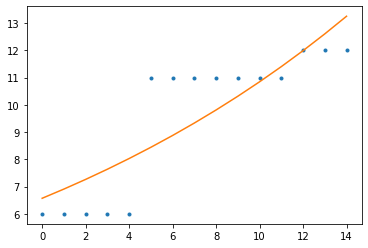

In [99]:
k=popt_francia[0]
t0=popt_francia[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

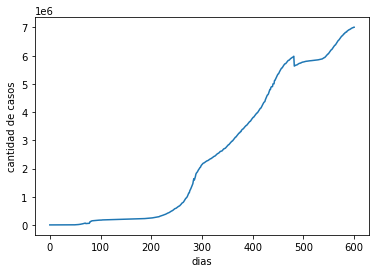

In [100]:
ind_francia=np.where(paises=='France')
ind_francia=ind_francia[0]
casos_francia=confirmados[ind_francia]
dias=np.arange(0,len(casos_francia))
plt.plot(dias,casos_francia)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 9. Brasil

In [101]:
brasil = datos_muestra[datos_muestra['location'] == 'Brazil']
brasil = brasil.reset_index(drop=True)
brasil.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,BRA,South America,Brazil,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,0.005,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,213993441.0,25.04,33.5,8.552,5.06,14103.452,3.4,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,NaN
1,BRA,South America,Brazil,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.005,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,213993441.0,25.04,33.5,8.552,5.06,14103.452,3.4,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,NaN
2,BRA,South America,Brazil,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.005,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,213993441.0,25.04,33.5,8.552,5.06,14103.452,3.4,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.765,NaN


In [102]:
brasil = brasil[['location','date','total_cases']].dropna()

In [103]:
casos_principio = brasil.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [104]:
casos_principio

10      13.0
11      20.0
12      25.0
13      31.0
14      38.0
15      52.0
16     151.0
17     151.0
18     162.0
19     200.0
20     321.0
21     372.0
22     621.0
23     793.0
24    1021.0
Name: total_cases, dtype: float64

In [105]:
# Ajustamos
popt_brasil, pcov_brasil = curve_fit(exponencial, dias_principio, casos_principio)
popt_brasil # Valor de k

array([ 0.29877229, -9.25236685])

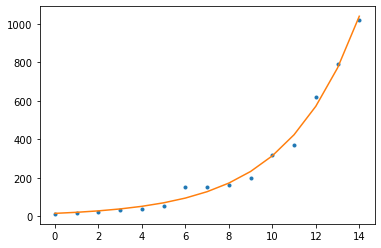

In [106]:
k=popt_brasil[0]
t0=popt_brasil[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

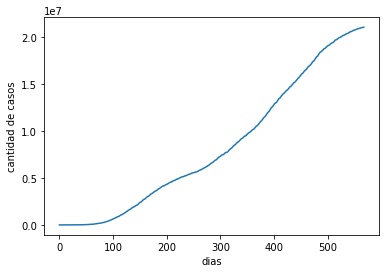

In [107]:
ind_brasil=np.where(paises=='Brazil')
ind_brasil=ind_brasil[0]
casos_brasil=confirmados[ind_brasil]
dias=np.arange(0,len(casos_brasil))
plt.plot(dias,casos_brasil)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### 10. Estados Unidos

In [108]:
eeuu = datos_muestra[datos_muestra['location'] == 'United States']
eeuu = eeuu.reset_index(drop=True)
eeuu.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
1,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
2,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN


In [109]:
eeuu = eeuu[['location','date','total_cases']].dropna()

In [110]:
casos_principio = eeuu.total_cases[10:25]
dias_principio = np.arange(0,len(casos_principio))

In [111]:
casos_principio

10     8.0
11     8.0
12    11.0
13    11.0
14    11.0
15    12.0
16    12.0
17    12.0
18    12.0
19    12.0
20    13.0
21    13.0
22    14.0
23    14.0
24    14.0
Name: total_cases, dtype: float64

In [112]:
# Ajustamos
popt_eeuu, pcov_eeuu = curve_fit(exponencial, dias_principio, casos_principio)
popt_eeuu # Valor de k

array([ 3.14648479e-02, -7.11561980e+01])

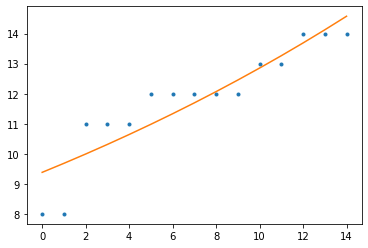

In [113]:
k=popt_eeuu[0]
t0=popt_eeuu[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Text(0, 0.5, 'cantidad de casos')

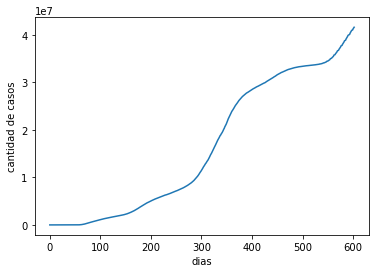

In [114]:
ind_eeuu=np.where(paises=='United States')
ind_eeuu=ind_eeuu[0]
casos_eeuu=confirmados[ind_eeuu]
dias=np.arange(0,len(casos_eeuu))
plt.plot(dias,casos_eeuu)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

## Los K obtenidos para los 10 paises analizados:

visualizamos a continuacion un resumen de todos los K por paises obtenidos anteriormente:

In [115]:
import pandas as pd
k_arg = round(popt[0],6)
k_alemania = round(popt_ger[0],6)
k_china = round(popt_china[0],6)
k_italia = round(popt_italia[0],6)
k_peru = round(popt_peru[0],6)
k_mexico = round(popt_mexico[0],6) 
k_reinoUnido = round(popt_reinoUnido[0],6) 
k_sudafrica = round(popt_sudafrica[0],6)
k_francia = round(popt_francia[0],6)
k_brasil = round(popt_brasil[0],6)
k_eeuu = round(popt_eeuu[0],6)

In [116]:
results = [['Argentina',k_arg],['Alemania',k_alemania],['China',k_china], ['Italia',k_italia],['Peru',k_peru], ['Mexico',k_mexico], ['Reino Unido',k_reinoUnido], ['Sudafrica',k_sudafrica], ['Francia',k_francia], ['Brasil',k_brasil], ['Estados Unidos',k_eeuu]]
table_result = pd.DataFrame(results, columns=['Pais', 'Valor_K'])
table_result

,Pais,Valor_K
0,Argentina,0.075216
1,Alemania,0.367804
2,China,0.101167
3,Italia,0.640554
4,Peru,0.136629
5,Mexico,0.234288
6,Reino Unido,0.049654
7,Sudafrica,0.199582
8,Francia,0.050044
9,Brasil,0.298772


## Metodo: boostraping

Utilizaremos el metodo boostrapping para analizar si sirve el K promedio que medimos desde nuestra muestra para representar la poblacion mundial. Ya que disponemos solamente de 10 pais seleccionados, siendo representativa de la poblacion, se puede esperar que los valores en la muestra aparezcan aproximadamente con la misma frecuencia que en la poblacion.
El metodo de boostrapping se basa en generar nuevas pseudo-muestras del mismo tamaño que la muestra original, mediante muestreo repetido de los datos con los que contamos. Si la muestra final es representativa de la poblacion, la distribucion del estadistico calculada a partir de las pseudo-muestras (bootstrapping distribution) se aproxima a la distribucion muestral que se obtendria si se pudiera acceder a la poblacion para generar nuevas muestras.

In [117]:
from sklearn.utils import resample

bootstrap = resample(table_result.Valor_K, replace = True, n_samples = 11, random_state = 40)
print(len(bootstrap)) 

bootstrap_mean =  np.mean(bootstrap)
print('Media bootstrap:', bootstrap_mean)
boot_95 = np.percentile(bootstrap, [2.5,97.5])
print('95% = ', boot_95)

11
Media bootstrap: 0.18412281818181817
95% =  [0.03601225 0.5723665 ]


Podemos analizar que la *media boostrap* y el *intervalo de confianza* que muestra tiene un rango muy amplio. Esto se puede deber a la distribucion de nuestros datos originales.
Los contagios crecen muy rapido, pero con el paso del tiempo empiezan a disminuir. Esto se debe a que cada pais cuenta con un K diferente a los demas, que posiblemente varie segun diversos factores como: cantidad de personas del pais, tamaño territorial, sistema de salud, entre otros.
Podriamos considerarlo como un buen modelo ya que teniendo en cuenta como son los datos originales, obtuvimos lo que se esperaba como resutado.

## Graficos que aportan informacion para la interpretacion de los datos

Graficaremos los diferentes valores de k para los distintos paises de la muestra, de mayor a menor.

In [118]:
# Usaremos el metodo "explode" para usar la columna "valor_k" de forma numerica (como float) para graficar:
table_result = table_result.explode('Valor_K') 
table_result['Valor_K'] = table_result['Valor_K'].astype('float')

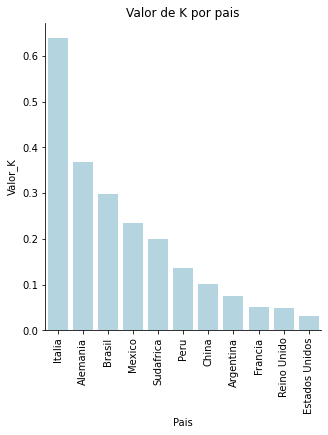

In [119]:
import seaborn as sbn

sbn.catplot(x = "Pais", y = "Valor_K", kind = "bar", data = table_result.sort_values('Valor_K',ascending=False),color = 'lightblue').set(title='Valor de K por pais')
plt.xticks(rotation=90)
warnings.filterwarnings("ignore")

Para saber cuantos casos hubo por dia a nivel mundial, agrupamos nuestros datos de la muestra por fecha.

In [120]:
datos_muestra_por_fecha=datos_muestra.groupby(['date'])['total_cases'].sum().reset_index()

In [121]:
datos_muestra_por_fecha.head(30)

,date,total_cases
0,2020-01-01,0.0
1,2020-01-02,0.0
2,2020-01-03,0.0
3,2020-01-04,0.0
4,2020-01-05,0.0
5,2020-01-06,0.0
6,2020-01-07,0.0
7,2020-01-08,0.0
8,2020-01-09,0.0
9,2020-01-10,0.0


In [125]:
# Separamos en 2 variables: 
# 1) los casos totales
# 2) los dias
total_cases_all_countrys=datos_muestra_por_fecha['total_cases']
dias=np.arange(0,len(datos_muestra_por_fecha))

Graficamos como fueron incrementando los casos a nivel mundial (teniendo en consideracion que solamente son los 10 paises de nuestra muestra representativa)

A la izquierda: la curva con el paso de mas de 600 dias.
A la derecha: como fueron variando los casos en los primeros 60 dias de pandemia.

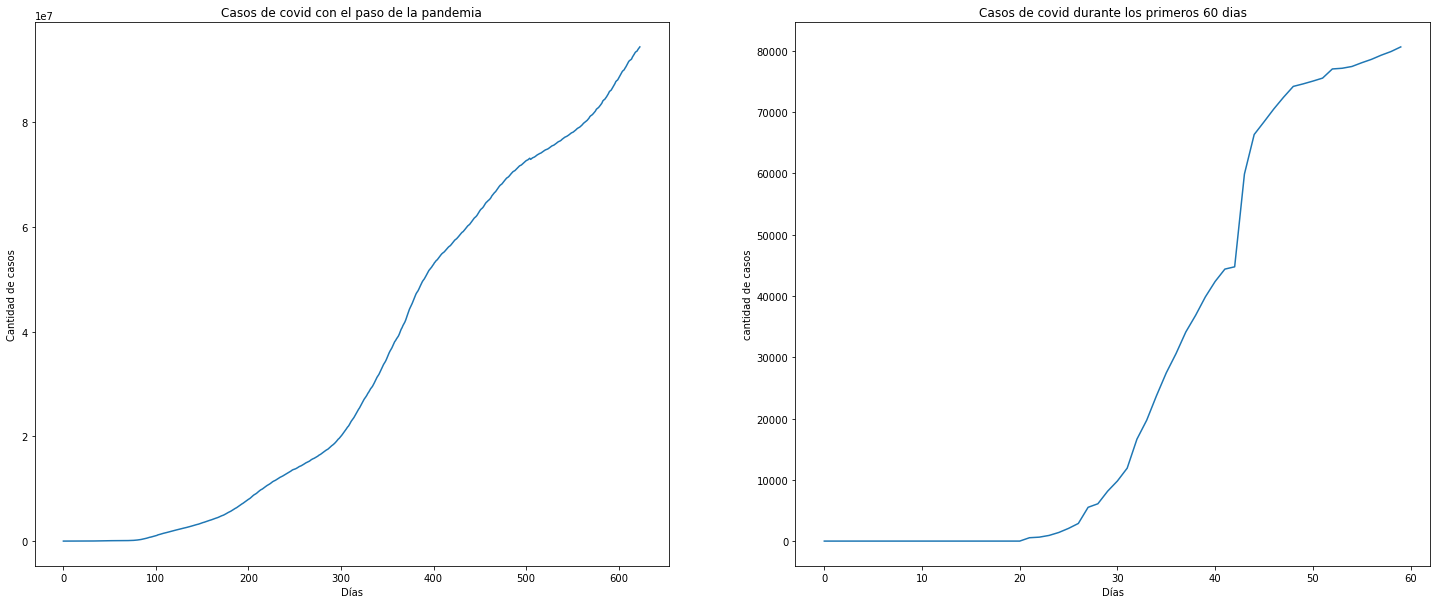

In [126]:
plt.figure(figsize = (25,10))
plt.subplot(1,2,1)
plt.plot(dias,total_cases_all_countrys)
plt.xlabel('Días')
plt.ylabel('Cantidad de casos')
plt.title('Casos de covid con el paso de la pandemia')
plt.subplot(1,2,2)
casos_principio=total_cases_all_countrys[0:60]
dias_principio=dias[0:60]
plt.plot(dias_principio,casos_principio)
plt.xlabel('Días')
plt.ylabel('cantidad de casos')
plt.title('Casos de covid durante los primeros 60 dias')
plt.show()

Nos detenemos en visualizar el comienzo de la pandemia:
- en el grafico de la izquierda nos enfocamos en la curva de los primeros 35 dias,
- en el grafico de la derecha nos enfocamos en el logaritmo de los casos de los 60 primeros dias.

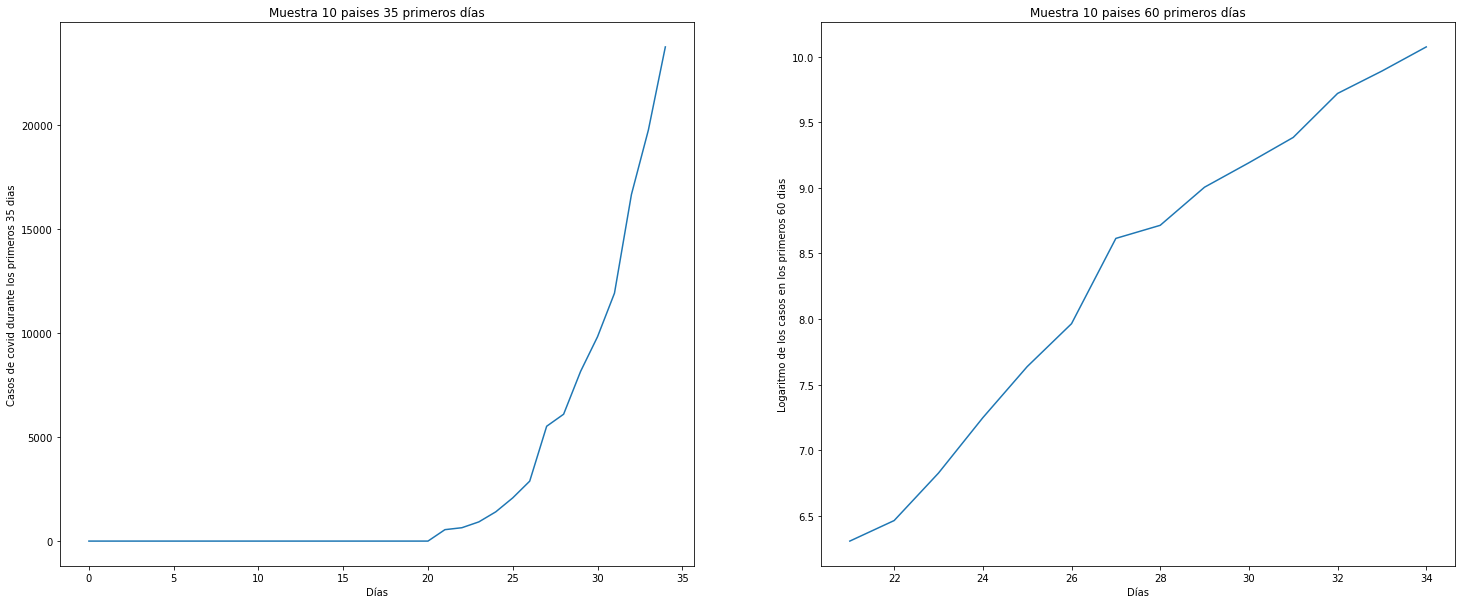

In [127]:
casos_principio=total_cases_all_countrys[0:35]
dias_principio=dias[0:35]
plt.figure(figsize = (25,10))
plt.subplot(1,2,1)
plt.plot(dias_principio,casos_principio)
plt.xlabel('Días')
plt.ylabel('Casos de covid durante los primeros 35 dias')
plt.title('Muestra 10 paises 35 primeros días')
plt.subplot(1,2,2)
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('Días')
plt.ylabel('Logaritmo de los casos en los primeros 60 dias')
plt.title('Muestra 10 paises 60 primeros días')
np.seterr(divide = 'ignore') 
plt.show()

Estimamos el valor de K para nuestro conjunto de 10 paises (nivel global), como lo hicimos en el comienzo de este trabajo

In [128]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [129]:
# Ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.24156523, -7.89121831])

Text(0.5, 1.0, 'Valores simulados vs reales - muestra de 10 paises')

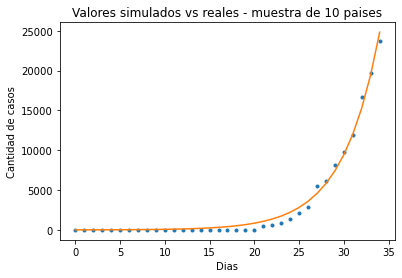

In [130]:
# Vemos como se ajusta lo que obtuvimos en relacion a los datos reales
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)
plt.xlabel('Dias')
plt.ylabel('Cantidad de casos')
plt.title('Valores simulados vs reales - muestra de 10 paises')

In [131]:
# Calculamos el desvio estandar
np.sqrt(pcov[0][0])

0.00660157541181064

In [132]:
# Calculamos el intervalo de confianza
z=1.96
n=35
intervalo_de_confianza=[popt[0]-z*np.sqrt(pcov[0][0])/np.sqrt(n),popt[0]+z*np.sqrt(pcov[0][0])/np.sqrt(n)]
print(intervalo_de_confianza)

[0.23937812295768796, 0.24375233300269505]


In [133]:
# Seleccionamos los casos mundiales de nuestro dataset inicial
casos_a_nivel_mundial=datos[datos['location']=='World'].groupby('date')['total_cases'].sum().reset_index()

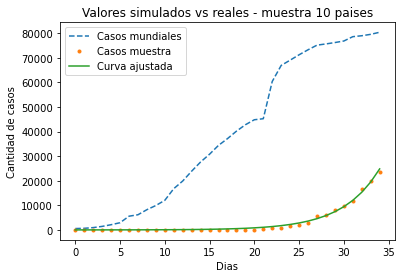

In [134]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_a_nivel_mundial['total_cases'][0:35].to_numpy(),'--')
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)
plt.xlabel('Dias')
plt.ylabel('Cantidad de casos')
plt.title('Valores simulados vs reales - muestra 10 paises')
plt.legend(('Casos mundiales', 'Casos muestra','Curva ajustada'))

In [135]:
# Calculamos nuestro error cuadratico medio
from sklearn.metrics import mean_squared_error
y_true = casos_principio
y_pred = casos_simu
mse = mean_squared_error(y_true, y_pred)
mse

277619.63029966404

In [136]:
import math
RMSE=math.sqrt(mse)
print(RMSE)

526.8962234630877


In [137]:
# Vamos a calcular nuestro coeficiente de determinación
from sklearn.metrics import r2_score
coefficient_of_dermination = r2_score(y_true,y_pred)
coefficient_of_dermination

0.9923590815273321

# Evaluando Estrategias

Se eligira a continuacion una politica publica para analizar sobre 5 paises que la hayan implementado y otros 5 paises que no la hayan implementado. 
Se eligiran tambien 3 indicadores asociados a esa politica publica que ayuden a construir un clasificador.

Se elige **la implementacion de una cuarentena estricta o no** como politica publica. 

Esta politica hace referencia a la columna **stringency_index** de nuestro dataset, la cual detalla: ¨Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)¨
Esta columna representa un **índice de rigurosidad** de la respuesta que dio cada gobierno frente a la pandemia. Es una **medida compuesta basada en 9 indicadores de respuesta** incluidos:
- cierres de escuelas, cierres de lugares de trabajo y prohibiciones de viaje, reescalado a un valor de 0 a 100 (100 = respuesta más estricta). 
Es decir, con esta columna, podemos tener una **medida o indice de restricción de actividades en cada país**.

Se eligen los siguientes indicadores de dicha politica:

1. **Cantidad de muertes**: cantidad de personas que murieron en un período de tiempo.
2. **Cantidad de contagios**: cantidad de personas que se contagiaron en un período de tiempo.
3. **Valor de k**: ver en que punto en el tiempo aumenta o baja el valor de stringency index.

Fueron elegidos dichos indicadores ya que estan muy relacionados con la politica publicada elegida, ya que como lo vivimos en la pandemia, a medida que la gente mas salia a eventos sociales, o se comenzaba a haber mayor movimiento, aumentaban la cantidad de contagios, y tambien se ocupaban mas camas en los hospitales, aumentando asi los porcentajes de ocupacion de los mismos, colapsando los resintos y aumentando la cantidad de muertes en adultos mayores sobre todo.

Se eligen 5 países que hayan **aplicado medidas restrictivas fuertes**, es decir, una cuarentena más estricta. 
- Con un **stringency_index > 60**

Se eligen tambien 5 países que **no las hayan aplicado** o que hayan sido mas relajados en las mismas.
- Con un **stringency_index < 60**

In [296]:
# Luego de investigar en internet los paises que hayan aplicado la cuarentena mas estricta y otros que no.
muestra_estrategia=['Italy','Argentina', 'China', 'Peru','Mexico','South Africa','Andorra','Thailand', 'Ukraine', 'Bulgaria']

In [297]:
#Filtramos nuestros datos usando la mascara
datos_muestra_estrategia=datos[datos.location.isin(muestra_estrategia)]

In [298]:
# Chequeamos que el filtrado se haya hecho de la forma deseada
datos_muestra_estrategia['location'].unique()

array(['Andorra', 'Argentina', 'Bulgaria', 'China', 'Italy', 'Mexico',
       'Peru', 'South Africa', 'Thailand', 'Ukraine'], dtype=object)

In [299]:
# Separamos los datos por países con mayor cuarentena
muestra_estrategia_Italy = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Italy'])]
muestra_estrategia_Argentina = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Argentina'])]
muestra_estrategia_China = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['China'])]
muestra_estrategia_Peru = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Peru'])]
muestra_estrategia_Mexico = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Mexico'])]

# Separamos los datos por países con menor cuarentena
muestra_estrategia_SA = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['South Africa'])]
muestra_estrategia_Andorra = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Andorra'])]
muestra_estrategia_Thailand = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Thailand'])]
muestra_estrategia_Ukraine = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Ukraine'])]
muestra_estrategia_Bulgaria = datos_muestra_estrategia[datos_muestra_estrategia.location.isin(['Bulgaria'])]

In [301]:
# Calculamos la mediana de la columna stringency_index para cada país.
# Para asegurarnos de que haya elegido bien 5 países con cuarentena estricta y 5 con cuarentena más relajada.
#+60
print('-----------------')
print('Argentina: ', muestra_estrategia_Argentina['stringency_index'].median())
print('China: ', muestra_estrategia_China['stringency_index'].median())
print('Peru: ', muestra_estrategia_Peru['stringency_index'].median())
print('Italy: ', muestra_estrategia_Italy['stringency_index'].median())
print('Mexico: ', muestra_estrategia_Mexico['stringency_index'].median())

print('-----------------')
#-60
print('SA: ', muestra_estrategia_SA['stringency_index'].median())
print('Thailand: ', muestra_estrategia_Thailand['stringency_index'].median())
print('Ukraine: ', muestra_estrategia_Ukraine['stringency_index'].median())
print('Andorra: ', muestra_estrategia_Andorra['stringency_index'].median())
print('Bulgaria: ', muestra_estrategia_Bulgaria['stringency_index'].median())

-----------------
Argentina:  79.17
China:  78.24
Peru:  75.93
Italy:  72.22
Mexico:  68.98
-----------------
SA:  51.85
Thailand:  52.78
Ukraine:  58.8
Andorra:  50.925
Bulgaria:  50.93


Verificamos que la mediana stringency_index sea < 60 (menos cuarentena) y > 60 (más cuarentena), para asegurarnos que elegimos los 5 paises con cuarentena mas estrictica y los 5 con cuarentena mas relajada. Ya que puede variar con el paso del tiempo este valor.

Entonces tenemos 5 países con cuanrentena mas estricta:

 1. Argentina
 2. China
 3. Peru
 4. Italy
 5. Mexico

Y 5 países con cuarentena menos estricta:
 1. Bulgaria
 2. SA
 3. Thailand
 4. Andorra
 5. Ukraine

In [302]:
# Visualizamos algunas columnas importantes que nos van a servir en el análisis de la estrategia de la cuarentena.
datos_muestra_estrategia[['stringency_index', 'date', 'location', 'total_cases', 'total_deaths']]

,stringency_index,date,location,total_cases,total_deaths
2289,0.0,2020-03-02,Andorra,1.0,NaN
2290,0.0,2020-03-03,Andorra,1.0,NaN
2291,0.0,2020-03-04,Andorra,1.0,NaN
2292,0.0,2020-03-05,Andorra,1.0,NaN
2293,0.0,2020-03-06,Andorra,1.0,NaN
...,...,...,...,...,...
109704,NaN,2021-09-11,Ukraine,2416739.0,57735.0
109705,NaN,2021-09-12,Ukraine,2419254.0,57772.0
109706,NaN,2021-09-13,Ukraine,2420776.0,57797.0
109707,NaN,2021-09-14,Ukraine,2424416.0,57913.0


Ahora vamos a medir los **indicadores** que definimos para elaborar modelos de regresión logística y poder usarlos en clasificaciones de otros países.

In [303]:
# Vamos limpiar los valores nulos en las columnas "location", "date" y "total cases" para poder luego hacer una correcta estimacion de k 
datos_muestra_estrategia.dropna(subset=['location', 'date', 'total_cases'], inplace=True)

In [304]:
# Comenzando midiendo el valor de K, nuestro factor de contagiabilidad.
print("Estimación de k:")
print("")
Estimacion_K=[]
Estimacion_Desvio=[]
Coef_variacion=[]
Cant_test=[]
Muerte=[]
Cant_confirmados=[]
for i in range(0,len(muestra_estrategia)):
    popt, pcov = curve_fit(exponencial, dias[0:60], datos_muestra_estrategia[datos_muestra_estrategia['location']==muestra_estrategia[i]].groupby('date')['total_cases'].sum()[0:60])
    print(muestra_estrategia[i],popt[0])
    Estimacion_K.append(popt[0])
    Estimacion_Desvio.append(np.sqrt(pcov[0][0]))
    Coef_variacion.append(np.sqrt(pcov[0][0])/ abs(popt[0]))
    muertes_i=pd.DataFrame(datos_muestra_estrategia[datos_muestra_estrategia['location']==muestra_estrategia[i]].groupby('location')['total_deaths'].sum()[0:60])
    muertes_i.reset_index(inplace=True)
    Muerte.append(muertes_i.loc[0,'total_deaths']) 
    
    test_i=pd.DataFrame(datos_muestra_estrategia[datos_muestra_estrategia['location']==muestra_estrategia[i]].groupby('location')['total_tests'].sum()[0:60])
    test_i.reset_index(inplace=True)
    Cant_test.append(test_i.loc[0,'total_tests']) 
    
    confirmados_i=pd.DataFrame(datos_muestra_estrategia[datos_muestra_estrategia['location']==muestra_estrategia[i]].groupby('location')['total_cases'].sum()[0:60])
    confirmados_i.reset_index(inplace=True)
    Cant_confirmados.append(test_i.loc[0,'total_tests']) 
    

Estimación de k:

Italy 0.10163528268134861
Argentina 0.05358992244752079
China 0.022740241808069196
Peru 0.08495862650057154
Mexico 0.08932497085479926
South Africa 0.05584129629375488
Andorra 0.03829067355057464
Thailand 0.16829201753914882
Ukraine 0.0773958610661201
Bulgaria 0.04582837139518682


In [305]:
# Vamos a armar un array de los targets entre 0 y 1 para el array de paises ordenado que elegimos
Target=[1,1,1,1,1,0,0,0,0,0]

In [306]:
# Armamos una tabla con la informacion calculada
tabla_resultados_estrategia=pd.DataFrame([muestra_estrategia,Estimacion_K,Estimacion_Desvio,Coef_variacion,Cant_test,Muerte,Cant_confirmados,Target], index=['Pais', 'Valor_K','Desvio','Coef_variacion','Cant_test' ,'Cant_muertes','cant_confirmados','Target']).T
tabla_resultados_estrategia

,Pais,Valor_K,Desvio,Coef_variacion,Cant_test,Cant_muertes,cant_confirmados,Target
0,Italy,0.101635,0.003067,0.030179,17709273303.0,39956999.0,17709273303.0,1
1,Argentina,0.05359,0.001899,0.03543,2744585551.0,23067660.0,2744585551.0,1
2,China,0.02274,0.002548,0.112053,250000000.0,2595192.0,250000000.0,1
3,Peru,0.084959,0.001696,0.01996,1016456855.0,56526283.0,1016456855.0,1
4,Mexico,0.089325,0.001201,0.013443,2012285135.0,69410987.0,2012285135.0,1
5,South Africa,0.055841,0.001331,0.023827,3666688798.0,17829803.0,3666688798.0,0
6,Andorra,0.038291,0.00296,0.077303,6694711.0,46052.0,6694711.0,0
7,Thailand,0.168292,0.01188,0.070594,1774386928.0,641171.0,1774386928.0,0
8,Ukraine,0.077396,0.002166,0.02798,2314150716.0,12263207.0,2314150716.0,0
9,Bulgaria,0.045828,0.001215,0.026512,577829902.0,4183916.0,577829902.0,0


In [309]:
# A continuación, vamos a probar el coeficiente de variación que relaciona la mediana y el desvio
def sigmoidea(x,x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [ np.median(np.array(tabla_resultados_estrategia['Target'])),1]

popt, pcov = curve_fit(sigmoidea, np.array(tabla_resultados_estrategia['Target']), np.array(tabla_resultados_estrategia['Coef_variacion']),p0, method='dogbox', maxfev=1000)
popt

array([4.5439974e+04, 6.7891326e-05])

Text(0.5, 1.0, 'Regresión logistica - Variable explicativa: Coeficiente de Variación')

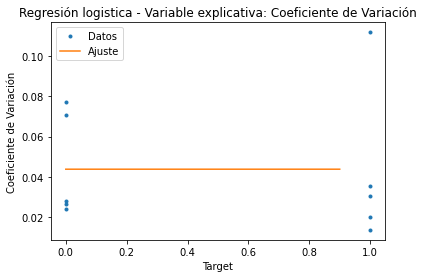

In [310]:
sigmoidea=np.vectorize(sigmoidea) # para hacer barrido por indices
x_plot=np.arange(min(np.array(tabla_resultados_estrategia['Target'])),max(np.array(tabla_resultados_estrategia['Target'])),0.1)
edad_ajustada=sigmoidea(x_plot,popt[0],popt[1])

plt.plot(np.array(tabla_resultados_estrategia['Target']),np.array(tabla_resultados_estrategia['Coef_variacion']),'.',label="Datos")
plt.plot(x_plot,edad_ajustada,label="Ajuste")
plt.legend()
plt.xlabel('Target')
plt.ylabel('Coeficiente de Variación')
plt.title('Regresión logistica - Variable explicativa: Coeficiente de Variación')

In [311]:
# Ahora vamos a probar con la variación de k
# Regresión logistica - Variable explicativa: Valor de K

def sigmoidea(x,x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [ np.median(np.array(tabla_resultados_estrategia['Target'])),1]

popt, pcov = curve_fit(sigmoidea, np.array(tabla_resultados_estrategia['Target']), np.array(tabla_resultados_estrategia['Valor_K']),p0, method='dogbox', maxfev=5000)
print(popt)

[8.01854057e+04 3.15504974e-05]


Text(0.5, 1.0, 'Regresión logistica - Variable explicativa: Valor de K')

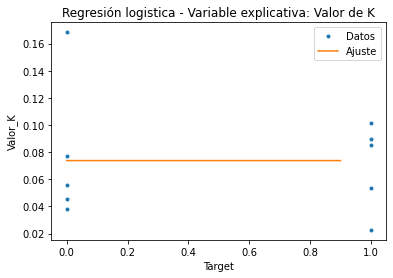

In [312]:
sigmoidea=np.vectorize(sigmoidea) #asi puedo poner un x que sea vector y sabe que tiene que hacer el barrido por indices
x_plot=np.arange(min(np.array(tabla_resultados_estrategia['Target'])),max(np.array(tabla_resultados_estrategia['Target'])),0.1)
edad_ajustada=sigmoidea(x_plot,popt[0],popt[1])

plt.plot(np.array(tabla_resultados_estrategia['Target']), np.array(tabla_resultados_estrategia['Valor_K']),'.',label="Datos")
plt.plot(x_plot,edad_ajustada,label="Ajuste")
plt.legend()
plt.xlabel('Target')
plt.ylabel('Valor_K')
plt.title('Regresión logistica - Variable explicativa: Valor de K')

In [313]:
# Regresión logistica - Variable explicativa: Cantidad de Muertes
# Ahora vamos a probar con el indice cantidad de muertes

def sigmoidea(x,x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [ np.median(np.array(tabla_resultados_estrategia['Target'])),1]

popt, pcov = curve_fit(sigmoidea, np.array(tabla_resultados_estrategia['Target']), np.array(tabla_resultados_estrategia['Cant_muertes']),p0, method='dogbox', maxfev=5000)
popt

array([-0.5       ,  0.99405057])

Text(0.5, 1.0, 'Regresión logistica - Variable explicativa: Cantidad de Muertes')

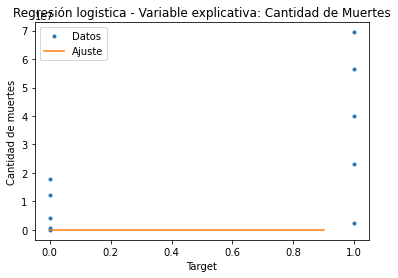

In [314]:
sigmoidea=np.vectorize(sigmoidea) #asi puedo poner un x que sea vector y sabe que tiene que hacer el barrido por indices
x_plot=np.arange(min(np.array(tabla_resultados_estrategia['Target'])),max(np.array(tabla_resultados_estrategia['Target'])),0.1)
edad_ajustada=sigmoidea(x_plot,popt[0],popt[1])

plt.plot(np.array(tabla_resultados_estrategia['Target']), np.array(tabla_resultados_estrategia['Cant_muertes']),'.',label="Datos")
plt.plot(x_plot,edad_ajustada,label="Ajuste")
plt.legend()
plt.xlabel('Target')
plt.ylabel('Cantidad de muertes')
plt.title('Regresión logistica - Variable explicativa: Cantidad de Muertes')

Y a continuación, vamos a ajustar una regresión logística teniendo en cuenta todos los atributos

In [315]:
# Vamos a comenzar creando un nuevo df tabla_resultados_estrategia_2, reseteando el index del mismo teniendo en cuenta el Pais
tabla_resultados_estrategia_2=tabla_resultados_estrategia
tabla_resultados_estrategia_2.set_index('Pais', inplace=True)

In [316]:
# A continuación podemos ver como queda la tabla con el indice País
tabla_resultados_estrategia_2

,Valor_K,Desvio,Coef_variacion,Cant_test,Cant_muertes,cant_confirmados,Target
Pais,,,,,,,
Italy,0.101635,0.003067,0.030179,17709273303.0,39956999.0,17709273303.0,1
Argentina,0.05359,0.001899,0.03543,2744585551.0,23067660.0,2744585551.0,1
China,0.02274,0.002548,0.112053,250000000.0,2595192.0,250000000.0,1
Peru,0.084959,0.001696,0.01996,1016456855.0,56526283.0,1016456855.0,1
Mexico,0.089325,0.001201,0.013443,2012285135.0,69410987.0,2012285135.0,1
South Africa,0.055841,0.001331,0.023827,3666688798.0,17829803.0,3666688798.0,0
Andorra,0.038291,0.00296,0.077303,6694711.0,46052.0,6694711.0,0
Thailand,0.168292,0.01188,0.070594,1774386928.0,641171.0,1774386928.0,0
Ukraine,0.077396,0.002166,0.02798,2314150716.0,12263207.0,2314150716.0,0


In [317]:
# Calculamos el promedio de las muertes, haciendo cantidad de muertes/cantidad de confirmados
tabla_resultados_estrategia_2['prom_muertes']=tabla_resultados_estrategia_2['Cant_muertes']/tabla_resultados_estrategia_2['cant_confirmados']

In [318]:
# Visualizamos esta nueva columna en nuestro dataframe
pd.DataFrame(tabla_resultados_estrategia_2)

,Valor_K,Desvio,Coef_variacion,Cant_test,Cant_muertes,cant_confirmados,Target,prom_muertes
Pais,,,,,,,,
Italy,0.101635,0.003067,0.030179,17709273303.0,39956999.0,17709273303.0,1,0.002256
Argentina,0.05359,0.001899,0.03543,2744585551.0,23067660.0,2744585551.0,1,0.008405
China,0.02274,0.002548,0.112053,250000000.0,2595192.0,250000000.0,1,0.010381
Peru,0.084959,0.001696,0.01996,1016456855.0,56526283.0,1016456855.0,1,0.055611
Mexico,0.089325,0.001201,0.013443,2012285135.0,69410987.0,2012285135.0,1,0.034494
South Africa,0.055841,0.001331,0.023827,3666688798.0,17829803.0,3666688798.0,0,0.004863
Andorra,0.038291,0.00296,0.077303,6694711.0,46052.0,6694711.0,0,0.006879
Thailand,0.168292,0.01188,0.070594,1774386928.0,641171.0,1774386928.0,0,0.000361
Ukraine,0.077396,0.002166,0.02798,2314150716.0,12263207.0,2314150716.0,0,0.005299


In [319]:
# Vamos a implementar el modelo
X = np.array(tabla_resultados_estrategia_2.drop(['Target'],1))
y = np.array(tabla_resultados_estrategia_2['Target']).astype('int')
X.shape

(10, 7)

In [320]:
#Ajustamos el modelo en train y test
model = linear_model.LogisticRegression()
model.fit(X,y)

LogisticRegression()

In [321]:
predictions = model.predict(X)
predictions_proba = model.predict_proba(X)

In [322]:
#Area bajo la curva
Auc=roc_auc_score(y, pd.DataFrame(predictions_proba)[1])
print('Area bajo la curva:',Auc)

Area bajo la curva: 0.88


Sin entrenar: ROC AUC=0.500
Regresión Logística: ROC AUC=0.880


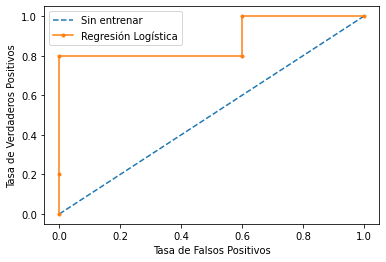

In [323]:
ns_probs = [0 for _ in range(len(y))]
# Entrenamos nuestro modelo de reg log

lr_probs = model.predict_proba(X)
# Nos quedamos con las probabilidades de la clase positiva (la probabilidad de 1)
lr_probs = lr_probs[:, 1]
# Calculamos el AUC
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# Imprimimos en pantalla
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Regresión Logística: ROC AUC=%.3f' % (lr_auc))
# Calculamos las curvas ROC
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# Pintamos las curvas ROC
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Regresión Logística')
# Etiquetas de los ejes
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()

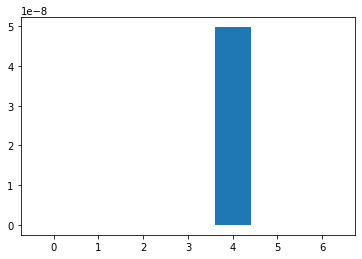

In [324]:
# Vamos a graficar el calculo de las feature importance
importance = model.coef_[0]
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [325]:
# Y a continuacion podemos ver cada atributo con su respectiva importance
importances = pd.DataFrame(data={
    'Attribute': tabla_resultados_estrategia_2[['Valor_K', 'Desvio', 'Coef_variacion', 'Cant_test', 'Cant_muertes',
       'cant_confirmados', 'prom_muertes']].columns,
    'Importance': model.coef_[0]
})
importances

,Attribute,Importance
0,Valor_K,-8.161333e-17
1,Desvio,-6.481427e-18
2,Coef_variacion,-3.011499e-17
3,Cant_test,-2.256555e-11
4,Cant_muertes,4.981186e-08
5,cant_confirmados,-2.256555e-11
6,prom_muertes,3.485825e-17


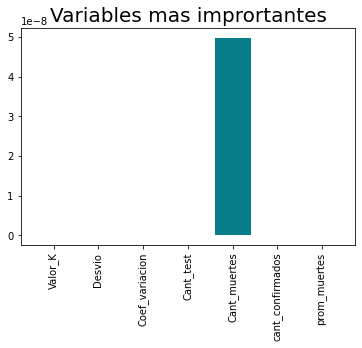

In [327]:
# Vamos a graficarlo, viendo que el atributo que aporta mayor informacion es la cantidad de muertes.
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Variables mas imprortantes', size=20)
plt.xticks(rotation='vertical')
plt.show()

# INVESTIGACION - INFORME

El informe final se encuentra en un documento pdf aparte, llamado LauraPognanteProyecto4_informe.pdf
Repo Github: https://github.com/lalipognante/informefinal

Plantea nuevas preguntas en base al trabajo que hiciste y en las que se pueda ahondar

Elabora un informe con todo lo que hiciste

Debes explicar qué te gustaría probar, por qué y cómo lo harías. Si tienes referencias (por ejemplo, un artículo que hayas encontrado, capítulo de libro, etc.) debes mencionarlas.

Debes comentar también qué resultados esperas encontrar. Por ejemplo, puedes implementar una prueba rápida y mostrar resultados preliminares, para ver si estás correctamente orientado.